In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import sys
import logging
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Add src directory to Python path
sys.path.append('../src')
from preprocessing import MIMICPreprocessor

In [3]:
# Set up paths
DATA_PATH = Path('../data')
PROCESSED_PATH = Path('../data/processed')
RANDOM_SEED = 42

In [4]:
# Initialize preprocessor
preprocessor = MIMICPreprocessor(DATA_PATH)
print("Starting preprocessing pipeline...")

try:
    # 1. Load all tables
    tables = preprocessor.load_tables()
    print("\nData Loading Summary:")
    for table_name, df in tables.items():
        print(f"{table_name}: {df.shape[0]} rows, {df.shape[1]} columns")
except Exception as e:
    print(f"Error during preprocessing: {str(e)}")
    raise

2024-12-01 22:42:12,174 - INFO - Loading MIMIC tables...


Starting preprocessing pipeline...


2024-12-01 22:42:55,514 - INFO - Successfully loaded NOTEEVENTS, shape: (2083180, 5)
2024-12-01 22:43:00,582 - INFO - Successfully loaded PRESCRIPTIONS, shape: (4156450, 14)
2024-12-01 22:43:00,615 - INFO - Successfully loaded PATIENTS, shape: (46520, 7)
2024-12-01 22:43:00,734 - INFO - Successfully loaded DIAGNOSES_ICD, shape: (651047, 4)



Data Loading Summary:
NOTEEVENTS: 2083180 rows, 5 columns
PRESCRIPTIONS: 4156450 rows, 14 columns
PATIENTS: 46520 rows, 7 columns
DIAGNOSES_ICD: 651047 rows, 4 columns


In [6]:
# Set up plotting style
sns.set_theme()  
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = [12, 8]

def plot_demographics(df: pd.DataFrame):
    """Plot key demographic distributions"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Patient Demographics Distribution', fontsize=16, y=1.02)
    
    # Only plot accurate ages (≤89)
    accurate_age_df = df[df['age_is_accurate']]
    
    # Age distribution for accurate ages
    sns.histplot(data=accurate_age_df, x='AGE', bins=30, ax=axes[0,0])
    axes[0,0].set_title('Age Distribution (≤89 years)')
    axes[0,0].set_xlabel('Age (years)')
    
    # Gender distribution
    df['GENDER'].value_counts().plot(kind='bar', ax=axes[0,1])
    axes[0,1].set_title('Gender Distribution')
    axes[0,1].set_ylabel('Count')
    
    # Age groups
    df['AGE_GROUP'].value_counts().plot(kind='bar', ax=axes[1,0])
    axes[1,0].set_title('Age Group Distribution')
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # Mortality status
    df['MORTALITY_STATUS'].value_counts().plot(kind='bar', ax=axes[1,1])
    axes[1,1].set_title('Mortality Status Distribution')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

def plot_prescriptions_summary(df: pd.DataFrame):
    """Plot prescription-related summaries"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Prescription Analysis', fontsize=16, y=1.02)
    
    # Top 10 medications
    med_counts = df['DRUG'].value_counts().head(10)
    med_counts.plot(kind='barh', ax=axes[0,0])
    axes[0,0].set_title('Top 10 Medications')
    
    # Route distribution
    route_counts = df['ROUTE'].value_counts().head(10)
    route_counts.plot(kind='barh', ax=axes[0,1])
    axes[0,1].set_title('Top 10 Administration Routes')
    
    # Medications per patient
    meds_per_patient = df.groupby('SUBJECT_ID')['DRUG'].nunique()
    sns.histplot(data=meds_per_patient, bins=30, ax=axes[1,0])
    axes[1,0].set_title('Medications per Patient')
    axes[1,0].set_xlabel('Number of Unique Medications')
    
    # Duration distribution
    sns.histplot(data=df['DURATION'].clip(0, 30), bins=30, ax=axes[1,1])
    axes[1,1].set_title('Prescription Duration Distribution (≤30 days)')
    axes[1,1].set_xlabel('Duration (days)')
    
    plt.tight_layout()
    plt.show()

def analyze_notes_summary(df: pd.DataFrame):
    """Print summary statistics for clinical notes"""
    print("\nClinical Notes Summary:")
    print("-" * 50)
    
    # Note length statistics
    note_lengths = df['cleaned_text'].str.len()
    print("\nNote Length Statistics:")
    print(note_lengths.describe().round(2))
    
    # Section presence
    print("\nSection Presence Statistics:")
    sections = df['sections'].apply(pd.Series)
    for column in sections.columns:
        present = (sections[column].str.len() > 0).sum()
        print(f"{column}: {present} notes ({present/len(df)*100:.2f}%)")


2024-12-01 22:49:33,910 - INFO - Processing demographics data...
2024-12-01 22:49:34,434 - INFO - 
Demographic Processing Summary:
2024-12-01 22:49:34,434 - INFO - Total patients: 46520
2024-12-01 22:49:34,435 - INFO - Patients with accurate age (≤89): 28386
2024-12-01 22:49:34,435 - INFO - Patients with age >89 (marked as 90+): 18134



Demographics Processing Summary:
Total patients: 46520
Patients with accurate age (≤89): 28386
Patients with age >89 (marked as 90+): 18134


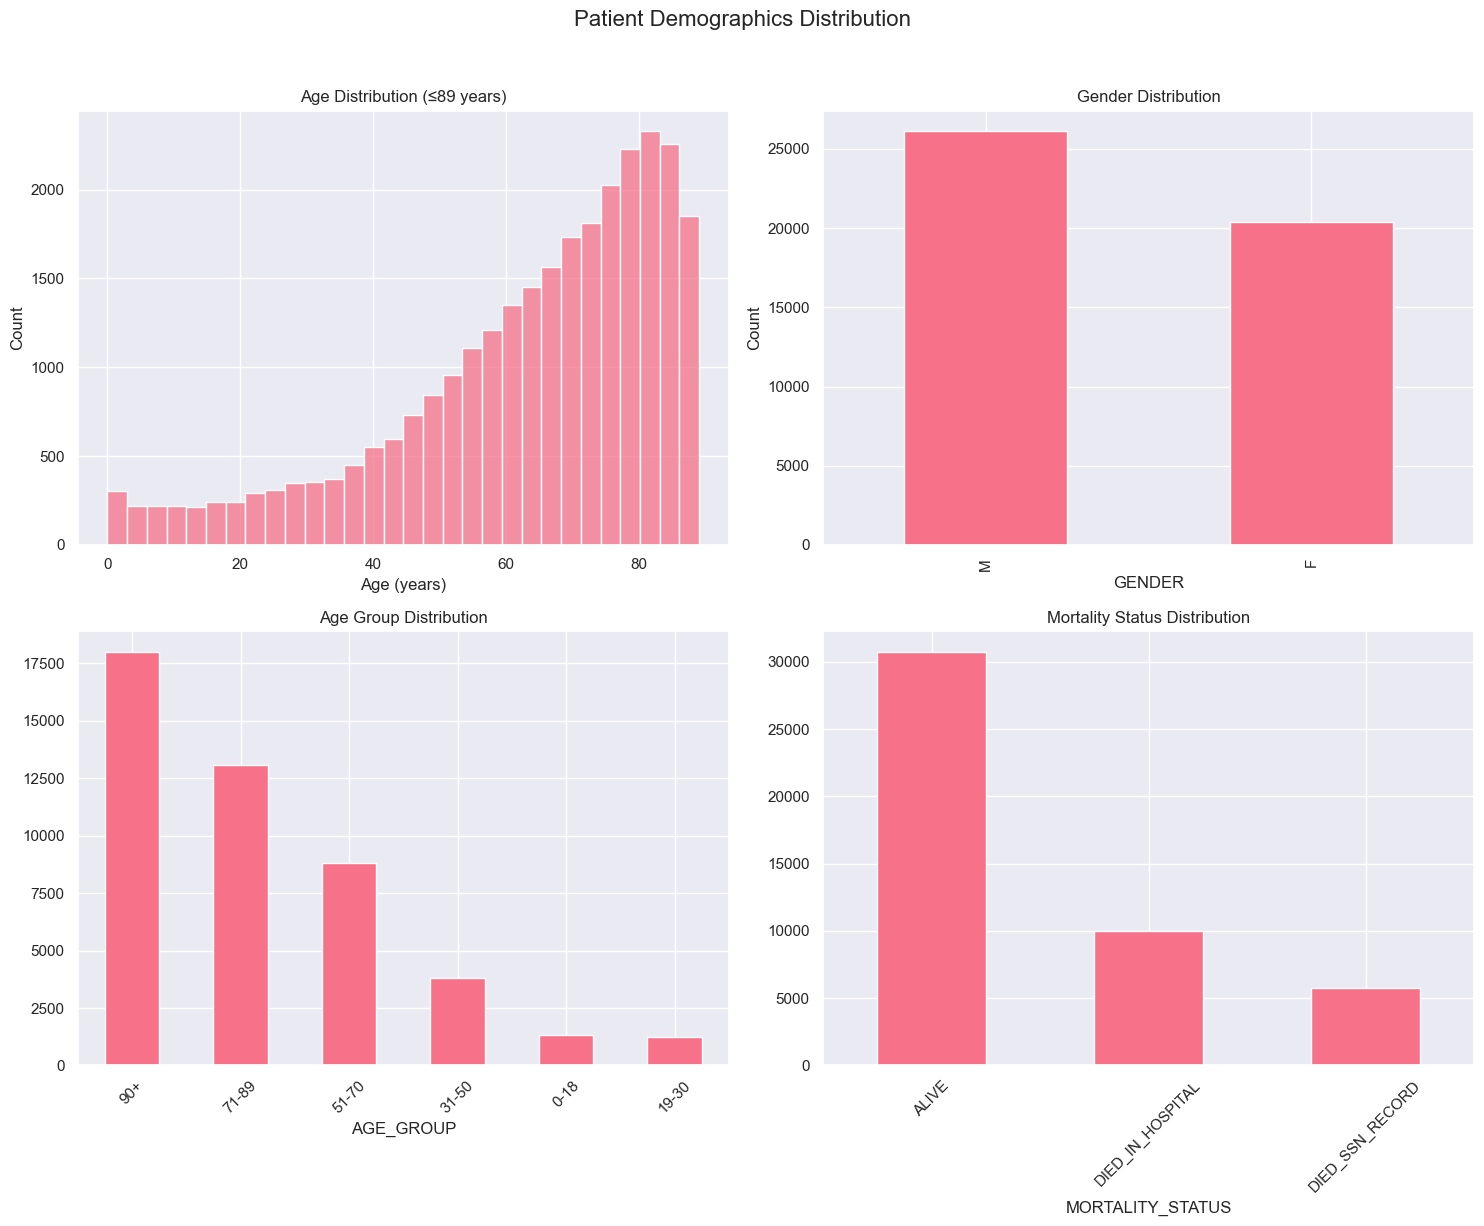

In [7]:
try:
    # 2. Process demographics
    patients_df = preprocessor.process_demographics(tables['PATIENTS'])
    print("\nDemographics Processing Summary:")
    print(f"Total patients: {len(patients_df)}")
    print(f"Patients with accurate age (≤89): {patients_df['age_is_accurate'].sum()}")
    print(f"Patients with age >89 (marked as 90+): {(~patients_df['age_is_accurate']).sum()}")

    # Plot demographic distributions
    plot_demographics(patients_df)
except Exception as e:
    print(f"Error during preprocessing: {str(e)}")
    raise

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
diagnoses_icd_path = '../data/DIAGNOSES_ICD.csv'

def analyze_diagnoses(diagnoses_icd_path):
    # Load diagnoses data
    diagnoses_df = pd.read_csv(diagnoses_icd_path)
    
    # Group diagnoses by category (first 3 digits of ICD9 code)
    diagnoses_df['category'] = diagnoses_df['ICD9_CODE'].astype(str).str[:3]
    
    # Map categories to readable names
    category_map = {
        '390': 'Cardiovascular',
        '460': 'Respiratory',
        '250': 'Endocrine',
        '290': 'Neurological',
        # Add more mappings as needed
    }
    
    # Count diagnoses by category
    category_counts = diagnoses_df['category'].value_counts()
    
    # Create pie chart
    plt.figure(figsize=(10, 8))
    plt.pie(category_counts[:5], labels=category_counts.index[:5], autopct='%1.1f%%',
            colors=sns.color_palette("husl", 5))
    plt.title('Distribution of Diagnoses in Dataset')
    
    return category_counts

def create_detailed_plot():
    # Create more detailed visualization with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    
    # Pie chart
    ax1.pie(diagnosis_counts, labels=labels, autopct='%1.1f%%')
    ax1.set_title('Diagnosis Distribution')
    
    # Bar chart for temporal analysis
    ax2.bar(range(len(diagnosis_counts)), diagnosis_counts)
    ax2.set_xticks(range(len(labels)))
    ax2.set_xticklabels(labels, rotation=45)
    ax2.set_title('Diagnosis Frequency')
    
    plt.tight_layout()
    plt.show()
    return fig

fig = create_detailed_plot
fig

<function __main__.create_detailed_plot()>

In [8]:
try: 
    # 3. Process clinical notes
    notes_df = preprocessor.clean_notes(tables['NOTEEVENTS'])
    print(f"\nProcessed {len(notes_df)} clinical notes")
    analyze_notes_summary(notes_df)

except Exception as e:
    print(f"Error during preprocessing: {str(e)}")
    raise

2024-12-01 22:49:38,162 - INFO - Starting clinical notes cleaning...
Cleaning text: 100%|██████████████████| 141624/141624 [00:27<00:00, 5207.92it/s]
/Users/jingl1/Documents/GitHub/DrugGPT/scripts/../src/preprocessing.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  notes_df['cleaned_text'] = notes_df['TEXT'].progress_apply(clean_text)
Extracting sections: 100%|████████████| 141624/141624 [00:35<00:00, 3954.26it/s]
/Users/jingl1/Documents/GitHub/DrugGPT/scripts/../src/preprocessing.py:320: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html


Processed 141624 clinical notes

Clinical Notes Summary:
--------------------------------------------------

Note Length Statistics:
count    141624.00
mean       5105.32
std        1964.69
min           5.00
25%        3838.00
50%        4858.00
75%        6096.00
max       20106.00
Name: cleaned_text, dtype: float64

Section Presence Statistics:
medications: 0 notes (0.00%)
diagnosis: 0 notes (0.00%)
lab_results: 0 notes (0.00%)
history: 0 notes (0.00%)


2024-12-01 22:50:50,157 - INFO - Processing prescription data...
2024-12-01 22:51:41,907 - INFO - Processed 4156450 prescriptions
2024-12-01 22:51:41,909 - INFO - Available columns after prescription processing:
2024-12-01 22:51:41,910 - INFO - ['SUBJECT_ID', 'HADM_ID', 'STARTDATE', 'ENDDATE', 'DRUG_TYPE', 'DRUG', 'DRUG_NAME_POE', 'DRUG_NAME_GENERIC', 'PROD_STRENGTH', 'DOSE_VAL_RX', 'DOSE_UNIT_RX', 'FORM_VAL_DISP', 'FORM_UNIT_DISP', 'ROUTE', 'DURATION', 'drug_id']



Processed 4156450 prescriptions
Unique medications: 3966


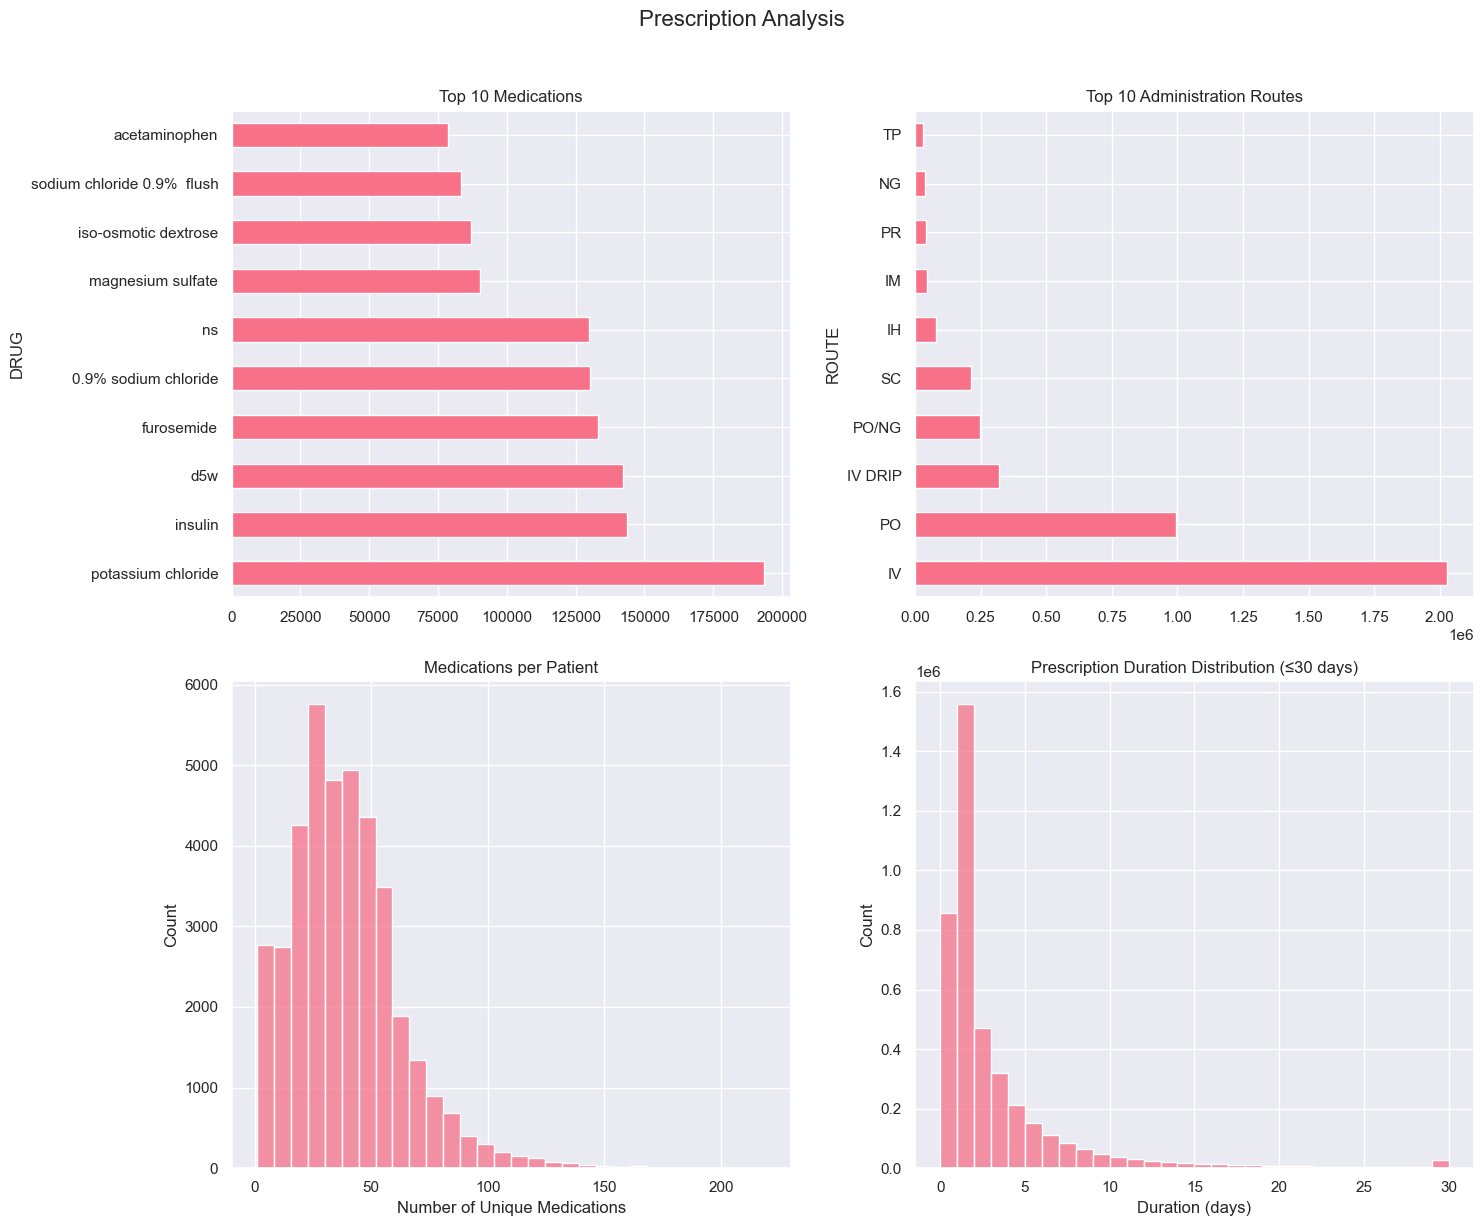

In [9]:
try:
    # 4. Process prescriptions
    prescriptions_df = preprocessor.process_prescriptions(tables['PRESCRIPTIONS'])
    print(f"\nProcessed {len(prescriptions_df)} prescriptions")
    print(f"Unique medications: {prescriptions_df['DRUG'].nunique()}")
    plot_prescriptions_summary(prescriptions_df)
except Exception as e:
    print(f"Error during preprocessing: {str(e)}")
    raise

In [ ]:
try:
    # 5. Merge all data
    merged_df = preprocessor.merge_patient_data(
        notes_df,
        prescriptions_df,
        tables['DIAGNOSES_ICD'],
        patients_df
    )
    print(f"\nFinal merged dataset shape: {merged_df.shape}")

except Exception as e:
    print(f"Error during preprocessing: {str(e)}")
    raise

2024-11-07 22:50:29,227 - INFO - Starting patient data merge...
2024-11-07 22:50:29,230 - INFO - Available columns before merge:
2024-11-07 22:50:29,233 - INFO - Notes columns: ['SUBJECT_ID', 'HADM_ID', 'CHARTDATE', 'CATEGORY', 'TEXT', 'cleaned_text', 'sections']
2024-11-07 22:50:29,233 - INFO - Prescriptions columns: ['SUBJECT_ID', 'HADM_ID', 'STARTDATE', 'ENDDATE', 'DRUG_TYPE', 'DRUG', 'DRUG_NAME_POE', 'DRUG_NAME_GENERIC', 'PROD_STRENGTH', 'DOSE_VAL_RX', 'DOSE_UNIT_RX', 'FORM_VAL_DISP', 'FORM_UNIT_DISP', 'ROUTE', 'DURATION', 'drug_id']
2024-11-07 22:50:29,234 - INFO - Diagnoses columns: ['SUBJECT_ID', 'HADM_ID', 'SEQ_NUM', 'ICD9_CODE']
2024-11-07 22:50:29,236 - INFO - Patients columns: ['SUBJECT_ID', 'GENDER', 'DOB', 'DOD', 'DOD_HOSP', 'DOD_SSN', 'EXPIRE_FLAG', 'AGE', 'AGE_GROUP', 'age_is_accurate', 'MORTALITY_STATUS']


In [ ]:
try:
    # 6. Generate and display demographic analysis
    demo_analysis = preprocessor.analyze_demographics(patients_df)
    print("\nDemographic Analysis Summary:")
    print(f"Total patients: {demo_analysis['patient_counts']['total']}")
    print(f"Gender distribution: {demo_analysis['patient_counts']['by_gender']}")
    print("\nMortality Statistics:")
    print(f"Overall mortality rate: {demo_analysis['mortality']['total_rate']:.2f}%")
    print("\nAge Group Distribution:")
    for group, count in demo_analysis['age_distribution']['by_group'].items():
        print(f"{group}: {count}")

    # 7. Create train-test split
    train_df, test_df = preprocessor.create_train_test_split(merged_df)
    print("\nTrain-Test Split:")
    print(f"Training set: {len(train_df)} samples")
    print(f"Test set: {len(test_df)} samples")

    # 8. Save processed data
    preprocessor.save_processed_data(train_df, test_df, PROCESSED_PATH)
    print(f"\nSaved processed data to {PROCESSED_PATH}")

    return train_df, test_df, demo_analysis

except Exception as e:
    print(f"Error during preprocessing: {str(e)}")
    raise


In [ ]:
# Additional analysis cells

# Example: Analyze medication patterns
def analyze_medication_patterns(df: pd.DataFrame):
    """Analyze medication patterns by age group and gender"""
    print("\nMedication Pattern Analysis:")
    print("-" * 50)
    
    # Average medications per patient by age group
    med_by_age = df.groupby('AGE_GROUP')['DRUG'].nunique().mean()
    print("\nAverage medications per patient by age group:")
    print(med_by_age)
    
    # Most common medications by age group
    print("\nTop 3 medications by age group:")
    for age_group in df['AGE_GROUP'].unique():
        top_meds = df[df['AGE_GROUP'] == age_group]['DRUG'].value_counts().head(3)
        print(f"\n{age_group}:")
        print(top_meds)
    
    # Medication routes by gender
    print("\nMost common administration routes by gender:")
    route_by_gender = df.groupby('GENDER')['ROUTE'].value_counts().unstack()
    print(route_by_gender)

# Example: Analyze temporal patterns
def analyze_temporal_patterns(df: pd.DataFrame):
    """Analyze temporal patterns in prescriptions"""
    df['STARTDATE'] = pd.to_datetime(df['STARTDATE'])
    
    # Prescriptions by month
    df['month'] = df['STARTDATE'].dt.month
    monthly_prescriptions = df['month'].value_counts().sort_index()
    
    plt.figure(figsize=(12, 6))
    monthly_prescriptions.plot(kind='bar')
    plt.title('Prescription Distribution by Month')
    plt.xlabel('Month')
    plt.ylabel('Number of Prescriptions')
    plt.show()

# Run additional analyses
print("\nRunning additional analyses...")
analyze_medication_patterns(train_df)
analyze_temporal_patterns(train_df)